In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
image_dir = "./lumbar_spinal_dataset" # lumbar_spinal_dataset 파일이 있는 디렉토리를 경로로 입력하세요. 

In [3]:
batch_size = 32
img_height = 224
img_width = 224 

In [ ]:
train_dir = "./lumbar_spinal_dataset/training" # training 파일이 있는 디렉토리를 경로로 입력하세요. 
test_dir = "./lumbar_spinal_dataset/testing" # testing 파일이 있는 디렉토리를 경로로 입력하세요. 

In [5]:
# 데이터 세트 만들기

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

print(train_ds.class_names)
print(val_ds.class_names)

Found 4808 files belonging to 3 classes.
Found 1158 files belonging to 3 classes.
['Herniated Disc', 'No Stenosis', 'Thecal Sac']
['Herniated Disc', 'No Stenosis', 'Thecal Sac']


In [ ]:
# 데이터 수 확인 
import os
from collections import Counter

train_dir = "./lumbar_spinal_dataset/training" # training 파일이 있는 디렉토리를 경로로 입력하세요. 

counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        counts[class_name] = len(os.listdir(class_path))

print(counts)

{'Herniated Disc': 1903, 'No Stenosis': 1542, 'Thecal Sac': 1363}


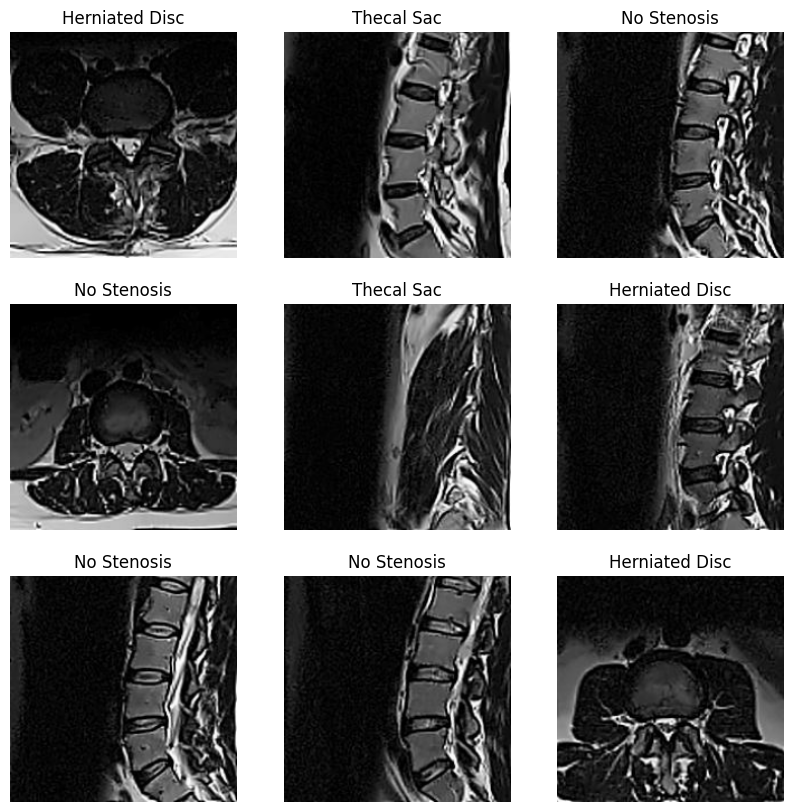

In [6]:
# 데이터 시각화하기
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9) : 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off") # 축 표시 없애기 

In [ ]:
# 이미지 shape 확인 (batch_size = 32, image_size = 224 * 224, layer = 3(RGB))
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break 

(32, 224, 224, 3)
(32,)


In [ ]:
# 데이터 표준화하기 (방법 1)
# RGB의 값 : [0 ~ 225] 범위 -> 신경망에 들어가기엔 너무 큼 -> 입력 값 작게 하기 

normalization_layer = tf.keras.layers.Rescaling(1./225) # [0 ~ 1] 범위로 표준화하기 

In [ ]:
# 데이터 표준화하기 (방법 2)
# dataset.map 호출하기 
normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y)) 
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) # 픽셀 values -> 0 ~ 1 사이로 평균화됨. 

0.0 1.1333333


In [ ]:
# 성능을 위한 데이터세트 구성
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# 모델 훈련하기 (모델 : simple CNN)
num_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes)
])

In [12]:
# 손실함수 및 옵티마이저
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [ ]:
# 모델 훈련하기 (epoch = 30)
hist = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.4006 - loss: 1.0872 - val_accuracy: 0.2858 - val_loss: 1.2983
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 35s 230ms/step - accuracy: 0.5543 - loss: 0.9179 - val_accuracy: 0.3670 - val_loss: 1.4509
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.7400 - loss: 0.6055 - val_accuracy: 0.3791 - val_loss: 2.2072
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.8559 - loss: 0.3679 - val_accuracy: 0.4119 - val_loss: 2.7187
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.9151 - loss: 0.2217 - val_accuracy: 0.4128 - val_loss: 3.2661
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.9328 - loss: 0.1726 - val_accuracy: 0.4680 - val_loss: 2.7619
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.9557 - loss: 0.1230 - val_accuracy: 0.4335 - val_loss: 3.7078
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.9567 - loss: 0

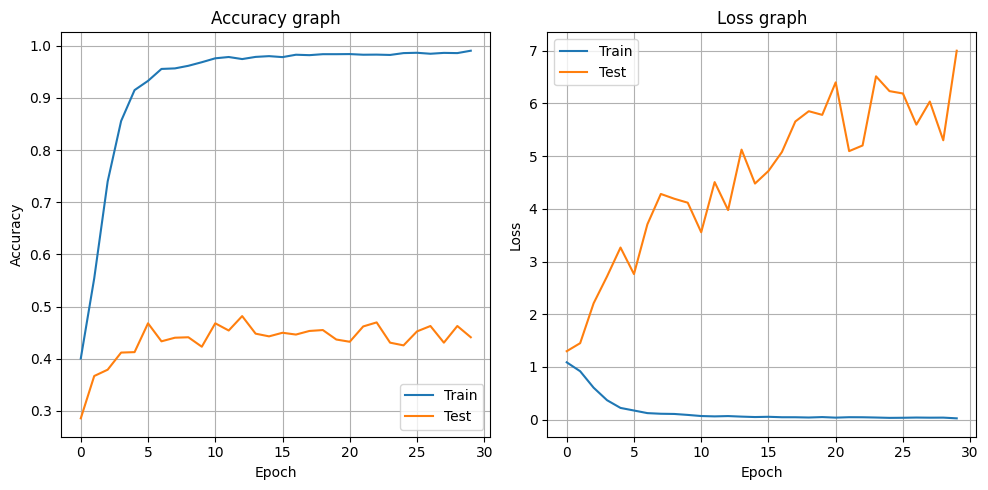

In [ ]:
# 정확도 및 손실 그래프 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(hist.history['accuracy'])
ax1.plot(hist.history['val_accuracy'])
ax1.set_title('Accuracy graph')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'])
ax1.grid()

ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_title('Loss graph')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'])
ax2.grid()

plt.tight_layout()
plt.show()

In [ ]:
# 한글폰트 적용
plt.rc('font', family='Malgun gothic')
plt.rcParams['axes.unicode_minus'] =False

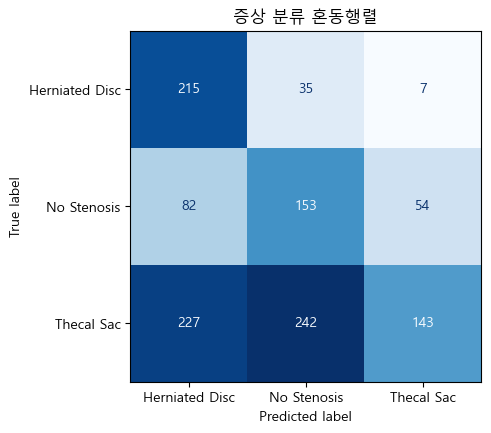

In [ ]:
# confusion matrix (혼동행렬)

true_labels = []
pred_labels  = []

for images, labels in val_ds:  # 각 배치 순회
    # 추론
    outputs = model(images, training=False)

    logits = outputs

    preds = tf.argmax(logits, axis=1)

    true_labels.append(labels.numpy())
    pred_labels.append(preds.numpy())

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

class_names = getattr(val_ds, "class_names", None)
if class_names is None:
    class_names = ['Herniated Disc', 'No Stenosis', 'Thecal Sac'] 


# 혼동행렬 계산 & 시각화
cm = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
ax.set_title("증상 분류 혼동행렬")
plt.tight_layout()
plt.show()